<a href="https://colab.research.google.com/github/bwbayu/TalentMatch/blob/development/model/training/Training_Glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gensim

In [ ]:
!pip install wordsegment
!pip install num2words
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 7.4 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=67658f5ba71f4b5bebf6a44015b1a0248f143baa08d7f0e125a06c92ea3da0a6
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/compfest dataset/dataset/combined_all_nverbs.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35413 entries, 0 to 35412
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   clean_data   35413 non-null  object
 1   text_length  35413 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 553.5+ KB


In [ ]:
def tokenize_text(text):
    return word_tokenize(text.lower())

df['tokenized_data'] = df['clean_data'].apply(tokenize_text)

In [ ]:
glove_file = '/content/drive/MyDrive/model/glove.6B.50d.txt'
glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/model/glove.6B.50d.txt'

In [ ]:
# model 10
base_model = Word2Vec(vector_size=300, min_count=5)
base_model.build_vocab(df['tokenized_data'])
total_examples = base_model.corpus_count

# model 50
base_model_50 = Word2Vec(vector_size=300, min_count=5)
base_model_50.build_vocab(df['tokenized_data'])
total_examples = base_model_50.corpus_count

In [ ]:
base_model.build_vocab([list(glove_model.key_to_index.keys())], update=True)

base_model_50.build_vocab([list(glove_model.key_to_index.keys())], update=True)

In [ ]:
total_examples = len(df['tokenized_data'])

In [ ]:
base_model.train(df['tokenized_data'], total_examples=total_examples, epochs=10)

(8833154, 9980770)

In [ ]:
base_model_50.train(df['tokenized_data'], total_examples=total_examples, epochs=50)

(44164606, 49903850)

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 53.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordsegment import load, segment
from num2words import num2words
from deep_translator import GoogleTranslator
from nltk.tag import pos_tag
import spacy
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

load()
translator = GoogleTranslator(source='id', target='en')

nlp = spacy.load("en_core_web_sm")

def split_text(text, max_length):
    # Fungsi untuk membagi teks menjadi bagian yang lebih kecil
    words = text.split()
    parts = []
    current_part = []

    for word in words:
        if len(' '.join(current_part + [word])) <= max_length:
            current_part.append(word)
        else:
            parts.append(' '.join(current_part))
            current_part = [word]

    if current_part:
        parts.append(' '.join(current_part))

    return parts

def translate_batch(text, max_length=4000):
    # Fungsi untuk menerjemahkan teks dalam batch
    parts = split_text(text, max_length)
    translated_parts = [translator.translate(part) for part in parts]
    return ' '.join(translated_parts)

def remove_verbs(text):
    doc = nlp(text)
    for token in doc:
        print(f"{token.text}: {token.pos_}")
    non_verbs = [token.text for token in doc if token.pos_ not in ["VERB"]]
    return ' '.join(non_verbs)

def preprocessing_data(text):
  # terjemah kata
  text = translate_batch(text)

  text = text.lower()
  text = remove_verbs(text)

  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  text = re.sub(r'[^\w\s]', ' ', text)
  text = text.replace('s1', 'bachelor')
  text = text.replace('s2', 'master')
  text = text.replace('s3', 'doctorate')
  text = text.replace('d3', 'associate degree')
  text = text.replace('d4', 'professional degree')

  # ubah angka jadi kata
  pattern = r'\b\d+\b'

  def replace_with_words(match):
      number = int(match.group())
      return num2words(number)

  text = re.sub(pattern, replace_with_words, text)

  # pisah kata yang gabung
  # ada error
  segmented_text = segment(text)
  text = ' '.join(segmented_text)

  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
  text = text.replace('\n', ' ')
  text = text.replace('etc', ' ')

  stop_words = set(stopwords.words('english'))
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word not in stop_words]

  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  preprocessed_text = ' '.join(tokens)

  # preprocessed_text = remove_verbs(preprocessed_text)

  return preprocessed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
job_description = "responsibility collect process analyze large datasets extract meaningful insights trends generate monitoring report needed ensure seamless monitoring reporting cycle work cross functional teams understand data needs provide relevant insights perform data validation ensure data accuracy integrity collaborate it teams ensure availability reliability data creating database schemas represent support business process stay date industry trends best practices data analysis visualization requirement bachelors degree data science reputable university fresh graduate outstanding performance welcome proficiency data analysis tools software sql excel python r similar experience data visualization tools tableau power bi similar strong analytical problem solving skills excellent attention detail accuracy good communication interpersonal skills ability convey complex data insights non technical audiences"
cv = "I am an analytical and detail-oriented Data Scientist with a strong background in data analysis, visualization, and database management. I possess proficiency in tools such as SQL, Excel, Python, and R, with a keen ability to extract meaningful insights from large datasets. I am an excellent communicator capable of conveying complex data insights to non-technical audiences. As a fresh graduate with outstanding academic performance and hands-on experience in data projects, I am eager to contribute my skills and knowledge to a dynamic team. I hold a Bachelor of Science in Data Science from a reputable university, where I graduated in June 2024 with a GPA of 3.95/4.00. My relevant coursework includes Data Analysis, Data Visualization, SQL, Python Programming, R Programming, and Database Management."
jd2 = "lead developer fullstack developer using java springboot react job description lead manage team developers providing technical guidance mentorship oversee design development implementation scalable web applications manage prioritize development pipeline monitor evaluate progress implement maintain ci cd pipelines using tools jenkins similar devops tools facilitate agile ceremonies sprint planning daily stand ups retrospectives identify address technical challenges bottlenecks within team resolve incidents ensure system availability within sla conduct code reviews provide constructive feedback team members foster collaborative innovative team environment stay updated emerging technologies industry trends drive continuous improvement education bachelor higher degree computer science related fields experience needed long duration needed experience length service five years professional experience software development least two years leadership role additional expertises need proficiency fullstack development expertise technologies spring boot react js strong understanding restful api design implementation experience databases oracle oracle pl sql familiarity version control systems git ci cd pipelines knowledge agile methodologies practices excellent leadership team management abilities strong problem solving skills attention detail effective communication interpersonal skills ability motivate inspire team members experience cloud services aws azure google cloud knowledge docker container orchestration familiarity project management tools jira confluence"

In [ ]:
jd = preprocessing_data(job_description)
cv = preprocessing_data(cv)
jd2 = preprocessing_data(jd2)

print(jd)
print(cv)
print(jd2)

responsibility: NOUN
collect: NOUN
process: NOUN
analyze: VERB
large: ADJ
datasets: NOUN
extract: VERB
meaningful: ADJ
insights: NOUN
trends: NOUN
generate: VERB
monitoring: NOUN
report: NOUN
needed: VERB
ensure: VERB
seamless: ADJ
monitoring: NOUN
reporting: VERB
cycle: NOUN
work: NOUN
cross: NOUN
functional: ADJ
teams: NOUN
understand: VERB
data: NOUN
needs: NOUN
provide: VERB
relevant: ADJ
insights: NOUN
perform: VERB
data: NOUN
validation: NOUN
ensure: VERB
data: NOUN
accuracy: NOUN
integrity: NOUN
collaborate: NOUN
it: PRON
teams: NOUN
ensure: VERB
availability: NOUN
reliability: NOUN
data: NOUN
creating: VERB
database: NOUN
schemas: NOUN
represent: VERB
support: NOUN
business: NOUN
process: NOUN
stay: VERB
date: NOUN
industry: NOUN
trends: NOUN
best: ADJ
practices: NOUN
data: NOUN
analysis: NOUN
visualization: NOUN
requirements: NOUN
bachelors: PROPN
degree: NOUN
data: NOUN
science: NOUN
reputable: ADJ
university: NOUN
fresh: ADJ
graduate: NOUN
outstanding: ADJ
performance: NOUN


In [ ]:
def average_vector(sentence, model):
    words = sentence.split()
    vector_list = []

    for word in words:
        if word in model.wv:
            vector_list.append(model.wv[word])

    if not vector_list:
        return np.zeros(model.vector_size)

    return np.mean(vector_list, axis=0)

In [ ]:
def word_contributions(sentence1, sentence2, model):
    words1 = sentence1.split()
    words2 = sentence2.split()

    common_words = set(words1).intersection(words2)

    contributions = {}
    for word in common_words:
        if word in model.wv:
            vec_word = model.wv[word].reshape(1, -1)
            vec_sentence1 = average_vector(sentence1, model).reshape(1, -1)
            vec_sentence2 = average_vector(sentence2, model).reshape(1, -1)

            sim1 = cosine_similarity(vec_word, vec_sentence1)[0][0]
            sim2 = cosine_similarity(vec_word, vec_sentence2)[0][0]

            contributions[word] = (sim1 + sim2) / 2

    return contributions

In [ ]:
# Menghitung vektor rata-rata untuk setiap kalimat
vector1 = average_vector(jd, model10)
vector2 = average_vector(jd2, model10)
vector3 = average_vector(cv, model10)

In [ ]:
similarity = cosine_similarity([vector1], [vector3])
similarity2 = cosine_similarity([vector2], [vector3])

print("for 10 epoch:")
print(f"Kesamaan antara kalimat jd dan cv: {similarity[0][0]}")
print(f"Kesamaan antara kalimat jd2 dan cv: {similarity2[0][0]}")

for 10 epoch:
Kesamaan antara kalimat jd dan cv: 0.838675320148468
Kesamaan antara kalimat jd2 dan cv: 0.6914427876472473


In [ ]:
contributions1 = word_contributions(jd, cv, model10)
contributions2 = word_contributions(jd2, cv, model10)

print("\nKata-kata yang membuat kalimat jd dan cv serupa:")
for word, contribution in contributions1.items():
    print(f"{word}: {contribution}")

print("\nKata-kata yang membuat kalimat jd2 dan cv serupa:")
for word, contribution in contributions2.items():
    print(f"{word}: {contribution}")


Kata-kata yang membuat kalimat jd dan cv serupa:
detail: 0.1361837536096573
experience: 0.45516836643218994
bachelor: 0.21932366490364075
database: 0.40236592292785645
visualization: 0.47202038764953613
excellent: 0.3385521173477173
sql: 0.4556054174900055
reputable: 0.09687164425849915
large: 0.3640759587287903
team: 0.1939774453639984
graduate: 0.11058397591114044
outstanding: 0.14738258719444275
fresh: 0.03831607103347778
meaningful: 0.1543671190738678
tool: 0.41531068086624146
analysis: 0.5109637379646301
data: 0.6104699969291687
ability: 0.40025365352630615
python: 0.3781082034111023
strong: 0.435779333114624
university: 0.051478054374456406
set: 0.2821767032146454
audience: 0.2184278964996338
analytical: 0.5181758403778076
nontechnical: 0.12228911370038986
insight: 0.36665111780166626
excel: 0.2563852071762085
science: 0.3380487561225891
skill: 0.45019614696502686
proficiency: 0.3761020302772522
relevant: 0.38866573572158813
performance: 0.17087388038635254
complex: 0.3995789289

In [ ]:
# Menghitung vektor rata-rata untuk setiap kalimat
vector1_50 = average_vector(jd, model50)
vector2_50 = average_vector(jd2, model50)
vector3_50 = average_vector(cv, model50)

In [ ]:
similarity_50 = cosine_similarity([vector1_50], [vector3_50])
similarity2_50 = cosine_similarity([vector2_50], [vector3_50])

print("for 50 epoch:")
print(f"Kesamaan antara kalimat jd dan cv: {similarity_50[0][0]}")
print(f"Kesamaan antara kalimat jd2 dan cv: {similarity2_50[0][0]}")

for 50 epoch:
Kesamaan antara kalimat jd dan cv: 0.42133739590644836
Kesamaan antara kalimat jd2 dan cv: 0.8521997332572937


In [ ]:
contributions1 = word_contributions(jd, cv, model50)
contributions2 = word_contributions(jd2, cv, model50)

print("\nKata-kata yang membuat kalimat jd dan cv serupa:")
for word, contribution in contributions1.items():
    print(f"{word}: {contribution}")

print("\nKata-kata yang membuat kalimat jd2 dan cv serupa:")
for word, contribution in contributions2.items():
    print(f"{word}: {contribution}")


Kata-kata yang membuat kalimat jd dan cv serupa:
database: 0.3318568468093872
communication: 0.1957397758960724
ability: 0.29015493392944336
problem: 0.18861272931098938
skill: 0.3442988693714142
science: 0.2926821708679199
bachelor: 0.12361519038677216
experience: 0.38176393508911133
team: 0.15643739700317383
software: 0.45441168546676636
university: 0.044621068984270096

Kata-kata yang membuat kalimat jd2 dan cv serupa:
stack: 0.35122960805892944
five: 0.1811729371547699
member: 0.12175917625427246
management: 0.3893547058105469
problem: 0.10825730860233307
lead: 0.15303266048431396
full: 0.08783716708421707
development: 0.4594123959541321
boot: 0.27243170142173767
role: 0.2007565200328827
ability: 0.2722695469856262
skill: 0.33186769485473633
computer: 0.23201048374176025
team: 0.24185842275619507
design: 0.3907355070114136
software: 0.5308446288108826
implementation: 0.315414160490036
two: 0.18774710595607758
communication: 0.22178637981414795
web: 0.30469974875450134
spring: 0.31

# Pre trained

In [ ]:
!pip install torchtext

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import torch
from torchtext.vocab import GloVe

# Menginisialisasi GloVe dengan dimensi 50
glove = GloVe(name='6B', dim=50)

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]
100%|█████████▉| 399999/400000 [00:17<00:00, 22483.33it/s]


In [ ]:
from collections import Counter

vocab = glove.stoi

# Count the occurrences of words (this is a proxy as actual frequencies are not provided in GloVe)
# We use the norms of the vectors to approximate word frequency
word_freq = Counter({word: glove.vectors[idx].norm().item() for word, idx in vocab.items()})

# Print the 20 most common words
print("Most common words in GloVe corpus:")
for word, freq in word_freq.most_common(20):
    print(f"{word}: {freq}")

Most common words in GloVe corpus:
non-families: 14.121562004089355
202-383-7824: 14.019739151000977
non-institutionalized: 12.844210624694824
www.star: 12.790447235107422
non-obligatory: 12.76219367980957
officership: 12.511541366577148
republish: 12.49128532409668
http://www.nyse.com: 12.43392276763916
20003: 12.401117324829102
25-64: 12.296163558959961
puhs: 12.197233200073242
dehl: 12.08194351196289
afptv: 12.08087158203125
eighteens: 12.039584159851074
computerologist: 12.01170825958252
http://www.nasdaq.com: 11.865079879760742
palaeographically: 11.725377082824707
story3d: 11.685689926147461
hushen: 11.67656421661377
warmian-masurian: 11.49421501159668


In [ ]:
important_words = {
    'python': 10.0,
    'machine learning': 2.0,
}

def average_vector_weighted(sentence, glove, important_words):
    words = sentence.split()
    vector_list = []

    for word in words:
        if word in glove.stoi:
            vector = glove[word].numpy()
            weight = important_words.get(word, 1.0)  # Dapatkan bobot atau default ke 1.0
            vector_list.append(vector * weight)

    if not vector_list:  # Jika tidak ada kata yang ditemukan
        return np.zeros(glove.dim)

    # Mengembalikan rata-rata vektor
    return np.mean(vector_list, axis=0)

In [ ]:
def average_vector_pre(sentence, glove):
    words = sentence.split()
    vector_list = []

    for word in words:
        # Ambil embedding dari kata jika tersedia
        if word in glove.stoi:
            vector_list.append(glove[word].numpy())

    if not vector_list:  # Jika tidak ada kata yang ditemukan
        return np.zeros(glove.dim)

    # Mengembalikan rata-rata vektor
    return np.mean(vector_list, axis=0)

In [ ]:
def word_contributions_pre(sentence1, sentence2, model):
    words1 = sentence1.split()
    words2 = sentence2.split()

    common_words = set(words1).intersection(words2)

    contributions = {}
    for word in common_words:
        if word in model.stoi:
            vec_word = model[word].reshape(1, -1)
            vec_sentence1 = average_vector_pre(sentence1, model).reshape(1, -1)
            vec_sentence2 = average_vector_pre(sentence2, model).reshape(1, -1)

            sim1 = cosine_similarity(vec_word, vec_sentence1)[0][0]
            sim2 = cosine_similarity(vec_word, vec_sentence2)[0][0]

            contributions[word] = (sim1 + sim2) / 2

    return contributions

In [ ]:
def word_contributions_weighted(sentence1, sentence2, glove, important_words):
    words1 = sentence1.split()
    words2 = sentence2.split()

    common_words = set(words1).intersection(words2)
    contributions = {}

    for word in common_words:
        if word in glove.stoi:
            vec_word = glove[word].numpy().reshape(1, -1)
            vec_sentence1 = average_vector_weighted(sentence1, glove, important_words).reshape(1, -1)
            vec_sentence2 = average_vector_weighted(sentence2, glove, important_words).reshape(1, -1)

            sim1 = cosine_similarity(vec_word, vec_sentence1)[0][0]
            sim2 = cosine_similarity(vec_word, vec_sentence2)[0][0]

            contributions[word] = (sim1 + sim2) / 2

    return contributions

In [ ]:
# Menghitung vektor rata-rata untuk setiap kalimat
vector1 = average_vector_pre(jd, glove)
vector2 = average_vector_pre(jd2, glove)
vector3 = average_vector_pre(cv, glove)

In [ ]:
similarity = cosine_similarity([vector1], [vector3])
similarity2 = cosine_similarity([vector2], [vector3])

print(f"Kesamaan antara kalimat cv dan jd: {similarity[0][0]}")
print(f"Kesamaan antara kalimat cv dan jd2: {similarity2[0][0]}")

Kesamaan antara kalimat cv dan jd: 0.9543687701225281
Kesamaan antara kalimat cv dan jd2: 0.9222950339317322


In [ ]:
contributions1 = word_contributions_pre(jd, cv, glove)
contributions2 = word_contributions_pre(jd2, cv, glove)

print("\nKata-kata yang membuat kalimat cv dan jd:")
for word, contribution in contributions1.items():
    print(f"{word}: {contribution}")

print("\nKata-kata yang membuat kalimat cv dan jd2:")
for word, contribution in contributions2.items():
    print(f"{word}: {contribution}")


Kata-kata yang membuat kalimat cv dan jd:
ability: 0.7643511295318604
performance: 0.718897819519043
skill: 0.6555231213569641
tool: 0.7696131467819214
data: 0.845285177230835
analysis: 0.8356708288192749
insight: 0.6457037925720215
python: 0.2664954364299774
audience: 0.533589243888855
bachelor: 0.4542832374572754
experience: 0.7736330628395081
university: 0.5383615493774414
science: 0.7498667240142822
database: 0.6892017126083374
proficiency: 0.5264156460762024
r: 0.3164910674095154
graduate: 0.5655832290649414
visualization: 0.5565621256828308
team: 0.5537725687026978
excel: 0.5223063230514526

Kata-kata yang membuat kalimat cv dan jd2:
science: 0.7411800622940063
ability: 0.763823926448822
five: 0.6307790279388428
skill: 0.6411377191543579
team: 0.6085482835769653
bachelor: 0.47072142362594604
tool: 0.7459321022033691
project: 0.730865478515625
experience: 0.7834159135818481
two: 0.6611106395721436
proficiency: 0.4753587245941162
management: 0.7758132219314575
knowledge: 0.7968839

# Visualization

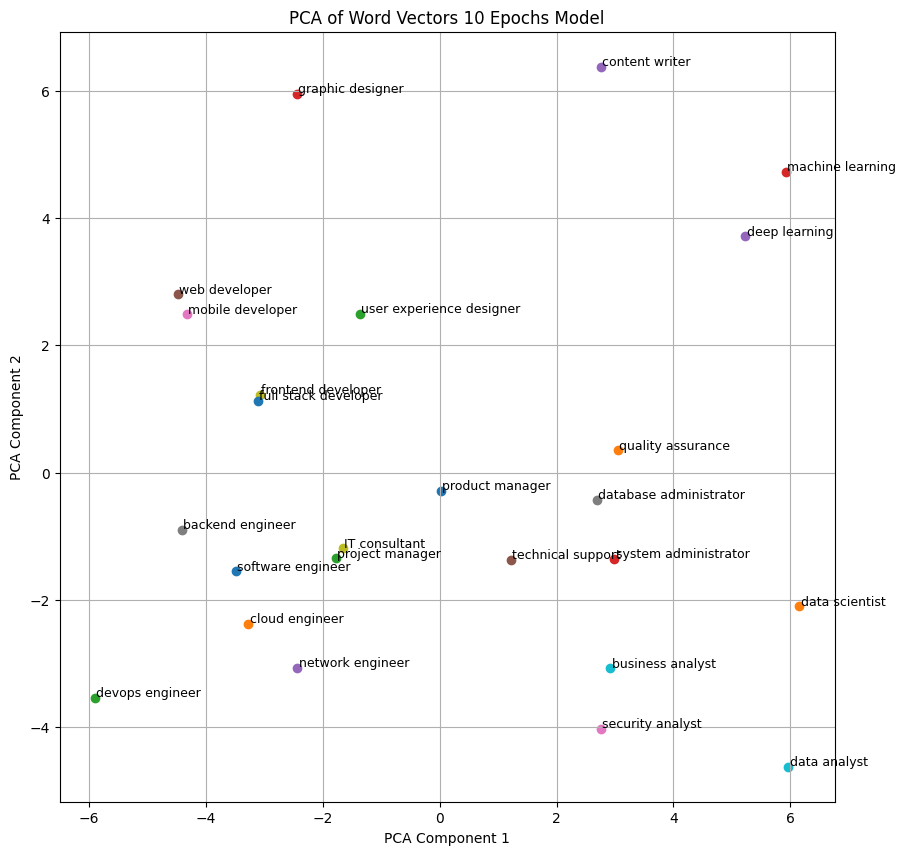

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# List kata atau frasa
words = [
    'software engineer', 'data scientist', 'project manager', 'machine learning', 'deep learning',
    'web developer', 'mobile developer', 'backend engineer', 'frontend developer', 'data analyst',
    'product manager', 'quality assurance', 'devops engineer', 'system administrator',
    'network engineer', 'technical support', 'security analyst', 'database administrator',
    'IT consultant', 'business analyst', 'full stack developer', 'cloud engineer',
    'user experience designer', 'graphic designer', 'content writer'
]

# Fungsi untuk mendapatkan vektor rata-rata dari sebuah frasa
def get_average_vector(words, model):
    word_vectors = []
    for word in words.split():
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # Jika tidak ada kata yang ditemukan, kembalikan vektor nol

# Menyimpan vektor kata
word_vectors = [get_average_vector(word, base_model) for word in words]

# Mengurangi dimensi vektor dari 300D ke 2D untuk visualisasi
pca = PCA(n_components=2)
result = pca.fit_transform(word_vectors)

# Visualisasi
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    plt.scatter(result[i, 0], result[i, 1])
    plt.text(result[i, 0] + 0.02, result[i, 1] + 0.02, word, fontsize=9)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Word Vectors 10 Epochs Model')
plt.grid()
plt.show()


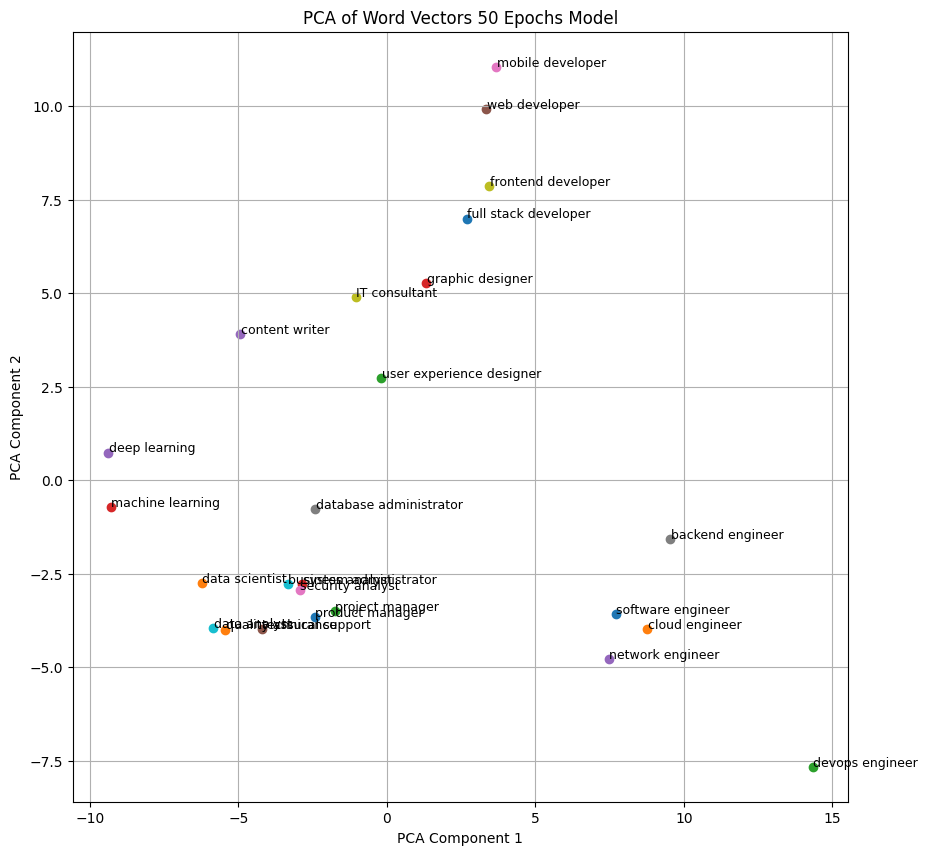

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# List kata atau frasa
words = [
    'software engineer', 'data scientist', 'project manager', 'machine learning', 'deep learning',
    'web developer', 'mobile developer', 'backend engineer', 'frontend developer', 'data analyst',
    'product manager', 'quality assurance', 'devops engineer', 'system administrator',
    'network engineer', 'technical support', 'security analyst', 'database administrator',
    'IT consultant', 'business analyst', 'full stack developer', 'cloud engineer',
    'user experience designer', 'graphic designer', 'content writer'
]

# Fungsi untuk mendapatkan vektor rata-rata dari sebuah frasa
def get_average_vector(words, model):
    word_vectors = []
    for word in words.split():
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # Jika tidak ada kata yang ditemukan, kembalikan vektor nol

# Menyimpan vektor kata
word_vectors = [get_average_vector(word, base_model_50) for word in words]

# Mengurangi dimensi vektor dari 300D ke 2D untuk visualisasi
pca = PCA(n_components=2)
result = pca.fit_transform(word_vectors)

# Visualisasi
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    plt.scatter(result[i, 0], result[i, 1])
    plt.text(result[i, 0] + 0.02, result[i, 1] + 0.02, word, fontsize=9)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Word Vectors 50 Epochs Model')
plt.grid()
plt.show()


# Evaluate

In [ ]:
model10 = Word2Vec.load("/content/drive/MyDrive/compfest dataset/model/glove_alldata_10.model")

vector = model10.wv['one']  # Ganti 'example_word' dengan kata yang diinginkan
print(vector)

[ 0.66730607  0.39942864 -1.3480053   0.48312205 -0.6054764   0.30325115
 -0.23680943  0.3926065   2.341113   -0.8413951  -0.42808175  1.0639435
 -1.8387847  -0.74092543  0.3700744   0.03994853  1.250145   -0.4634712
 -0.17263055 -0.37489203 -0.3692984  -3.7730253   0.88525546  1.4462851
 -1.2223958  -1.0783774   1.2381481  -1.3348383   0.45723316  1.9790221
  0.8609307   0.41960323 -0.3347041  -3.0889935   1.2158339  -0.26582238
  0.06627349  2.0511324  -0.70552003 -2.1372952   1.7936785   0.04823665
  0.75410956  0.0045984  -0.04764777 -2.3177376  -0.7667799   0.13685994
 -0.5508031  -0.16021846 -0.36155143  1.9441017  -1.6251339  -0.23903637
  1.3241217  -1.5469605  -1.2005386   0.3227686  -0.5356589   0.12964004
  1.9003813  -0.49801615 -1.6894472   1.4306486  -1.3962985   0.00451634
  0.8760351  -1.9729552  -0.50261587  0.88261217 -0.25766075  0.55028677
  0.2766046   1.2681727   0.63036364 -1.6052092   0.94317377  3.1989186
  1.3152109  -3.3988254  -1.4760977   1.3728812  -0.0803

In [ ]:
model50 = Word2Vec.load("/content/drive/MyDrive/compfest dataset/model/glove_alldata_50.model")

vector = model50.wv['one']  # Ganti 'example_word' dengan kata yang diinginkan
print(vector)

[ 4.5680010e-01  1.5684054e+00 -1.8644618e+00  1.3424358e-01
  6.8941104e-01 -3.7711723e+00  1.2897754e+00  7.3185241e-01
  2.6835134e+00  1.4743711e+00 -2.5043104e+00  2.0876851e+00
 -1.2859406e+00 -1.1684715e+00 -2.1693792e+00 -7.5380647e-01
  2.9643047e+00  1.7940453e+00  1.3248677e+00 -7.0089817e-01
  6.2529290e-01 -2.4653795e+00  1.7702156e+00  1.1409329e+00
  5.6084961e-01 -5.0350553e-01  2.7341540e+00  9.2322373e-01
 -1.5827166e+00  7.8101224e-01 -1.1021086e+00  2.3582799e+00
 -9.7666085e-01 -3.6134143e+00  3.4441340e+00 -1.5308503e+00
 -2.5564923e+00  5.2288985e-01 -1.3230605e+00  1.1566578e+00
  1.0234530e+00 -2.4606310e-01  2.9664856e-01 -6.6401291e-01
 -1.4680955e+00 -4.9912472e+00 -1.1092424e+00 -1.0235014e+00
  2.3386257e+00  5.7542884e-01  3.2541209e-01  3.8457918e-01
 -2.4166110e-01  2.8210890e-01  1.7645224e+00  1.4328370e+00
 -1.9086546e+00  2.0332606e+00  7.5449455e-01 -7.5729555e-01
  8.1982166e-01  9.9204683e-01 -3.1016212e+00  7.3714972e-01
  2.5279922e+00  4.00181

In [ ]:
vocab = model50.wv.key_to_index
word_freq = {word: model50.wv.get_vecattr(word, "count") for word in vocab}

# Use Counter to find the most common words
word_counter = Counter(word_freq)

# Print the 20 most common words
print("Most common words in the Word2Vec corpus:")
for word, freq in word_counter.most_common(20):
    print(f"{word}: {freq}")

Most common words in the Word2Vec corpus:
data: 101468
experience: 79382
work: 55628
year: 46801
team: 41840
business: 39874
skill: 39217
customer: 27552
job: 27461
good: 26996
company: 26364
minimum: 26202
product: 25752
degree: 25382
science: 22847
able: 22817
analysis: 22377
management: 22153
learning: 21750
project: 21089
